In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(12,9)})

from wrangle_zillow import wrangle_zillow, scaled_zillow_columns
from explore import elbow_plot, run_kmeans, add_to_train

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train, validate, test = wrangle_zillow()


In [3]:
train.head()

,parcelid,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,latitude,longitude,poolcnt,regionidcity,regionidzip,roomcnt,...,land_dollar_per_sqft,bed_bath_ratio,county,los_angeles,orange,ventura,central_heating,floor_wall_heating,no_heating,error
32407,12221537,3.0,1273.0,0.0,33945254.0,-118273655.0,0.0,12447.0,95984.0,0.0,...,27.301519,1.5,los_angeles,1,0,0,0,1,0,0.268492
32997,10767808,3.0,1380.0,0.0,34216726.0,-118580211.0,0.0,12447.0,96341.0,0.0,...,40.653641,1.5,los_angeles,1,0,0,1,0,0,-0.024149
32855,12029607,3.0,1703.0,0.0,34115303.0,-118326170.0,0.0,12447.0,96049.0,0.0,...,182.645955,1.5,los_angeles,1,0,0,1,0,0,0.003382
18482,14315204,2.0,2031.0,0.0,33581141.0,-117828130.0,1.0,40009.0,96978.0,6.0,...,159.613282,1.0,orange,0,1,0,0,0,1,0.041605
24544,12474338,3.0,1729.0,0.0,33850508.0,-118165817.0,0.0,12292.0,96212.0,0.0,...,59.574468,1.5,los_angeles,1,0,0,1,0,0,-0.001376


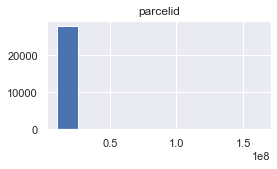

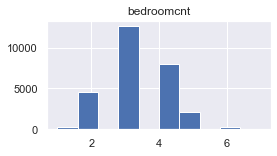

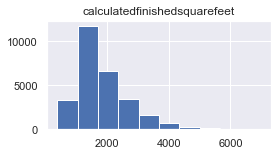

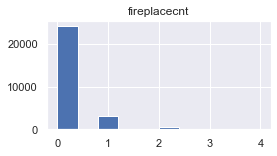

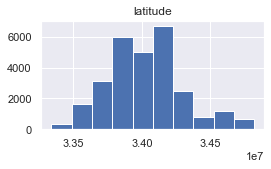

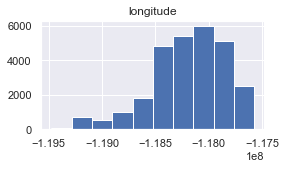

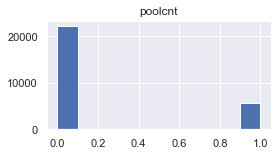

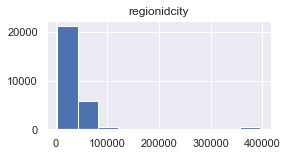

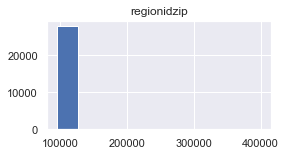

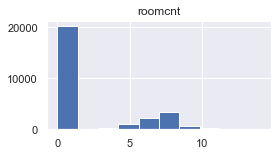

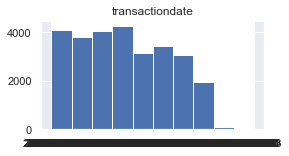

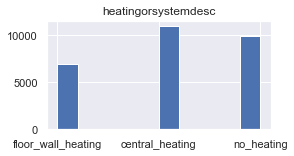

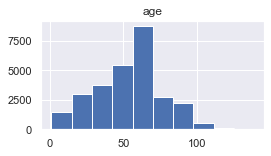

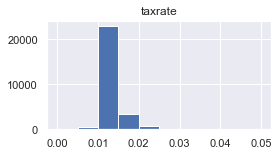

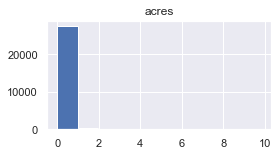

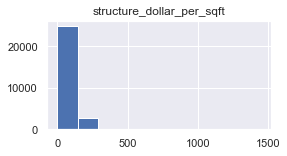

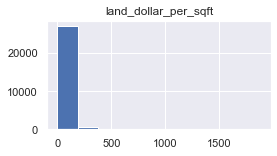

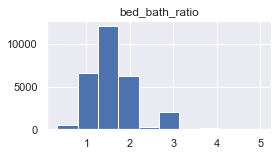

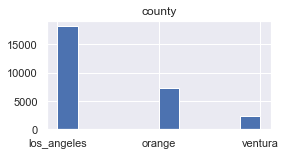

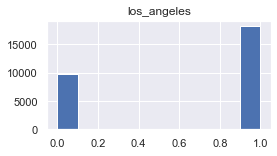

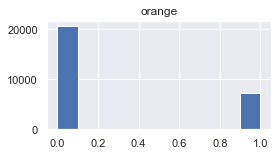

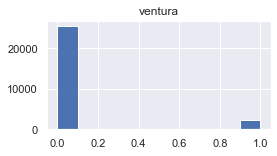

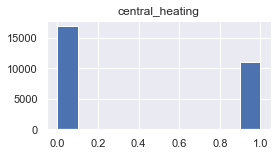

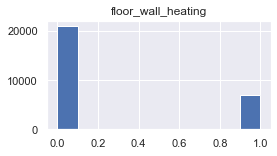

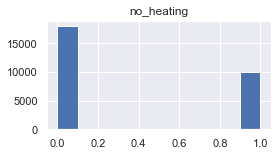

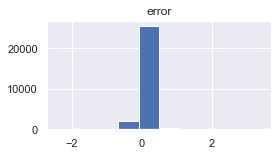

In [4]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

Conclusion: There is no a linear relationship between logerror and calculatedfinishedsquarefeet. 



Is there a relationship
between logerror and calculatedfinishedsquarefeet?


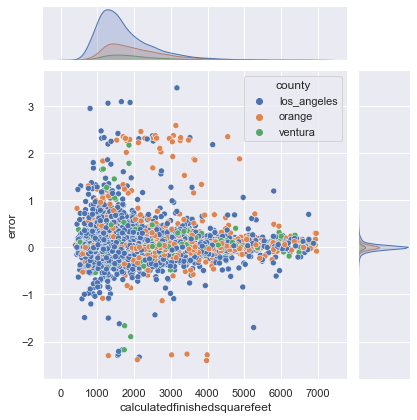

In [5]:
print("Is there a relationship\nbetween logerror and calculatedfinishedsquarefeet?")
sns.jointplot(x="calculatedfinishedsquarefeet", y="error", data=train, hue='county')
plt.xlabel("bedroomcnt")
plt.ylabel("calculatedfinishedsquarefeet")
plt.show()

Conclusion: There is no a linear relationship between logerror and calculatedfinishedsquarefeet. 


Is there a relationship
between fireplacecnt and roomcnt?


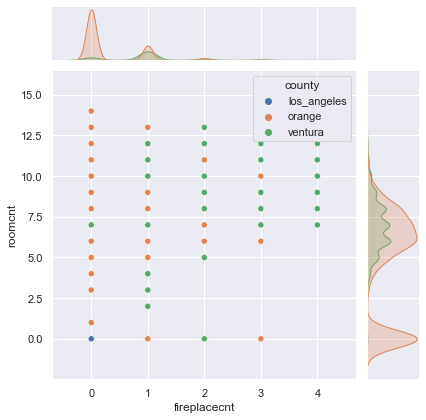

In [6]:
print("Is there a relationship\nbetween fireplacecnt and roomcnt?")
sns.jointplot(x="fireplacecnt", y="roomcnt", data=train, hue='county')
plt.xlabel("fireplacecnt")
plt.ylabel("roomcnt")
plt.show()

In [7]:
X_train = train.drop(columns=['error'])
y_train = train[['error']]

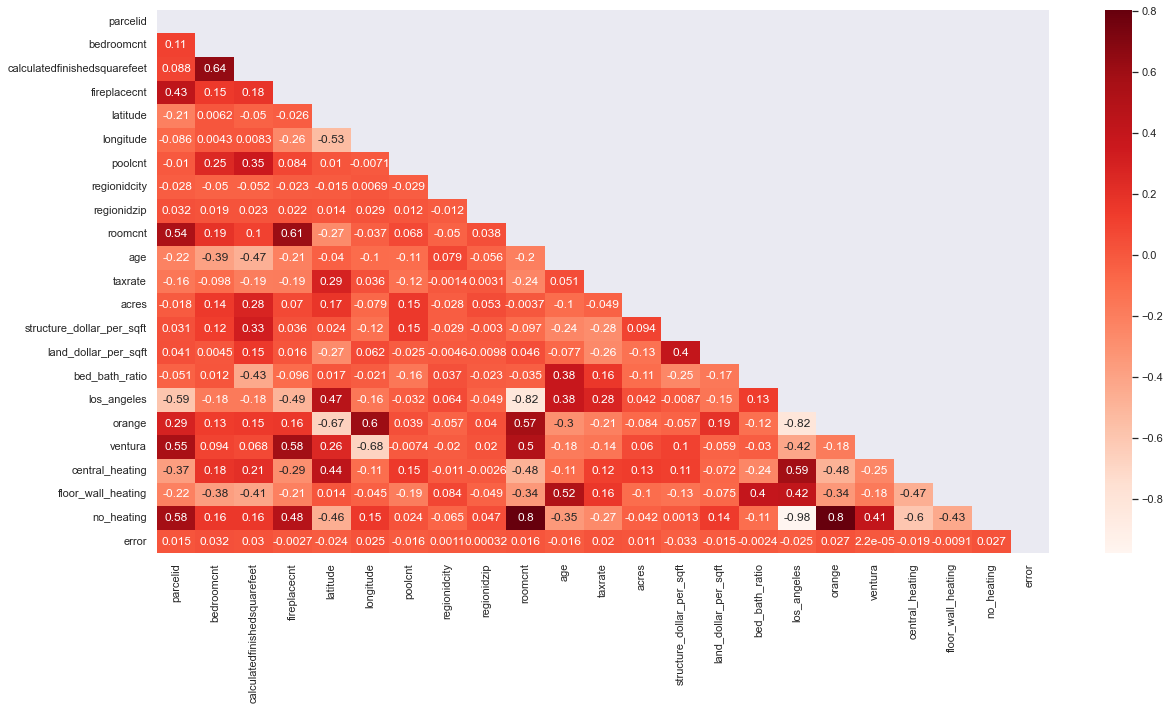

In [8]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), cmap='Reds', annot=True, mask=mask)
plt.show()

In [9]:
import math
abs(train.corr().error).sort_values(ascending = False)

error                           1.000000
structure_dollar_per_sqft       0.032991
bedroomcnt                      0.031790
calculatedfinishedsquarefeet    0.030269
orange                          0.027129
no_heating                      0.027107
longitude                       0.025376
los_angeles                     0.025052
latitude                        0.023663
taxrate                         0.020288
central_heating                 0.018522
poolcnt                         0.015922
roomcnt                         0.015894
age                             0.015559
parcelid                        0.015402
land_dollar_per_sqft            0.014654
acres                           0.010879
floor_wall_heating              0.009072
fireplacecnt                    0.002726
bed_bath_ratio                  0.002376
regionidcity                    0.001073
regionidzip                     0.000318
ventura                         0.000022
Name: error, dtype: float64

**Conclusion:**

- structure dollar per sqft has the highest correlation overall to logerror
- Orange and LA county are in the top 7 with having the highest correlation to logerror
- longitude and latitude are also in the top ten but that makes sense given that Orange and LA are listed higher
- There is a difference in errors but it is significant?

In [10]:
train.age.max()

139.0

In [11]:
# create age bins for age of propertys in 10 year blocks 
train['age_bin'] = pd.cut(train.age, [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140])

train.age_bin.sort_values().unique()

[(0, 10], (10, 20], (20, 30], (30, 40], (40, 50], ..., (90, 100], (100, 110], (110, 120], (120, 130], (130, 140]]
Length: 14
Categories (14, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (100, 110] < (110, 120] < (120, 130] < (130, 140]]

In [12]:
train.age_bin


32407    (70, 80]
32997    (60, 70]
32855    (60, 70]
18482    (40, 50]
24544    (40, 50]
           ...   
10502    (60, 70]
50088    (70, 80]
34274    (40, 50]
2850     (60, 70]
16021    (60, 70]
Name: age_bin, Length: 27955, dtype: category
Categories (14, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (100, 110] < (110, 120] < (120, 130] < (130, 140]]

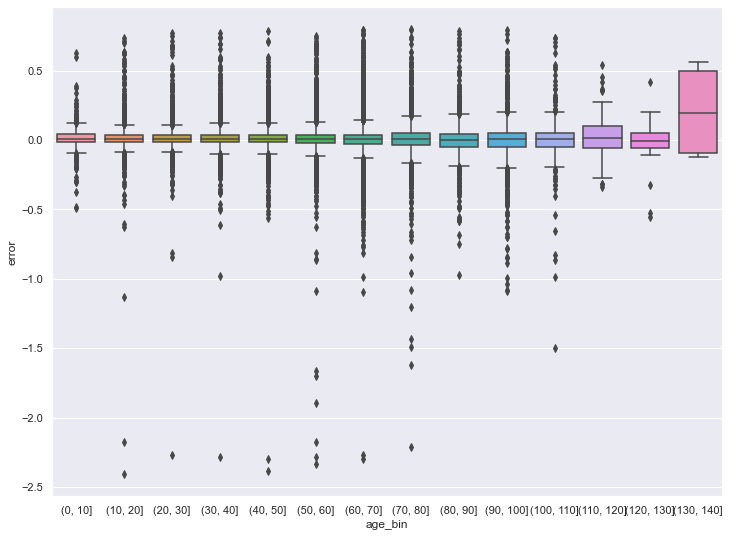

In [36]:
# box plot of the two groups age_bin and error
subset = train[train.error < 0.8]
sns.boxplot(x=subset.age_bin, y=subset.error)

plt.show()

The logerror for propertys under 70 years seem to be low but when the age of the property reaches around 130 year there is a large increase in the property logerror rate.

I will run a two-sample, two-tailed t-test just to confirm the sample sizes aren't leading us to make false assumptions. It is clear the variances when the age reaches over 100 years, but let's run a test to conform the results.

In [39]:
# test the assumption of equal variance
alpha = 0.5

stats.levene(train[train.age <= 130].error, 
             train[train.age > 130].error
            )


LeveneResult(statistic=9.528690461036845, pvalue=0.0020248225447567596)

In [40]:
p < alpha

True

In [41]:
# variances are unequal
# t-test, 2-sample (independent), 2-tail. 

stats.ttest_ind(train[train.age <= 130].error, 
                train[train.age > 130].error,
                equal_var=False
               )

Ttest_indResult(statistic=-1.0372954797748566, pvalue=0.37586199716497126)

In [42]:
p < alpha

True

**Conclusion:** there is a significant difference in logerror for home of ages > 130 vs those < 130.
    

In [14]:
la_error = train[train.los_angeles == 1].error
orange_error = train[train.orange == 1].error
ventura_error = train[train.ventura == 1].error

Equal Variance?



In [15]:
from scipy import stats

stats.levene(la_error, orange_error, ventura_error)

LeveneResult(statistic=18.929427065016213, pvalue=6.0899900130145475e-09)

In [16]:
alpha = .05


In [17]:
from scipy.stats import f_oneway


In [18]:
f, p = f_oneway(la_error, orange_error, ventura_error)
p


2.3769601834158e-05

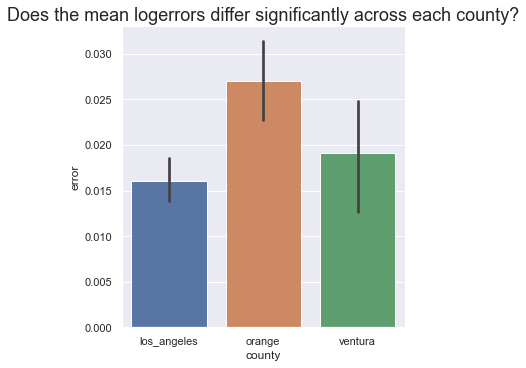

In [19]:
sns.catplot(x="county", y="error", kind="bar", data=train)
plt.title("Does the mean logerrors differ significantly across each county?", size = 18)
plt.show()

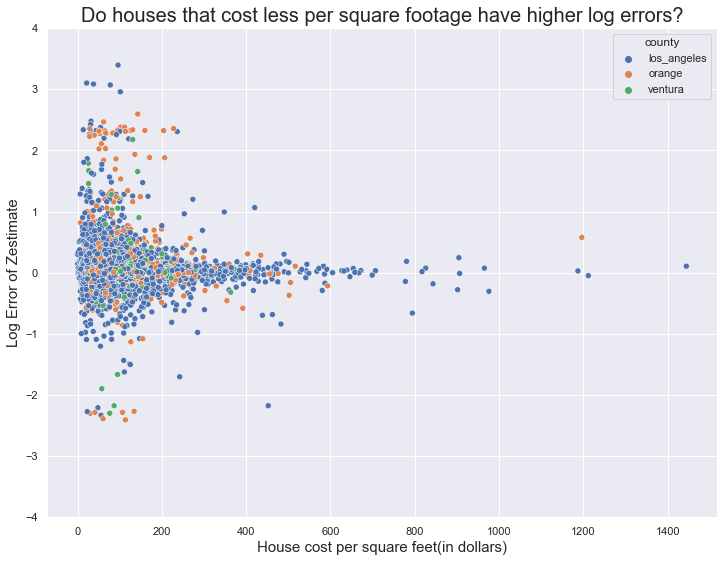

In [20]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'error', data = train, hue = 'county')
plt.title("Do houses that cost less per square footage have higher log errors?", size = 20)
plt.xlabel("House cost per square feet(in dollars)", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-4, 4)
plt.show()

Is there a significance?



- null_hypothesis = "Log errors in low cost per sqft are the same as the log errors for the rest of the houses"
- alternative_hypothesis = "Log errors in low cost per sqft are different than the log errors for the rest of the houses" 

In [21]:
low_cost_sqft = train[train.structure_dollar_per_sqft < 200]
t, p = stats.ttest_1samp(low_cost_sqft.error, train.error.mean())
t, p

(0.3241526634826559, 0.7458249674639303)

Is there a significant difference in logerrors between bedrooms?



In [22]:
one_bed = train[train.bedroomcnt == 1].error
two_bed = train[train.bedroomcnt == 2].error
three_bed = train[train.bedroomcnt == 3].error
four_bed = train[train.bedroomcnt == 5].error
five_bed = train[train.bedroomcnt == 4].error
six_bed = train[train.bedroomcnt == 6].error
seven_bed = train[train.bedroomcnt == 7].error

In [23]:
f, p = f_oneway(one_bed, two_bed, three_bed, four_bed, five_bed, six_bed, seven_bed)
p

1.2878894227156024e-06

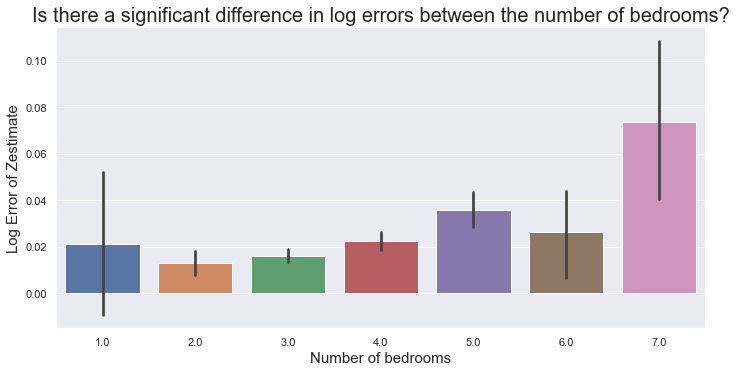

In [24]:
sns.catplot(x="bedroomcnt", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Is there a significant difference in log errors between the number of bedrooms?", size = 20)
plt.xlabel("Number of bedrooms", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

In [25]:
train_scaled, validate_scaled, test_scaled = scaled_zillow_columns()


In [26]:
X_train_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_train_scaled = train_scaled[['error']]
X_validate_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_validate_scaled = train_scaled[['error']]
X_test_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_test_scaled = train_scaled[['error']]

In [27]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

In [28]:
X_train_scaled.isna().sum()

heatingorsystemdesc                    0
county                                 0
los_angeles                            0
orange                                 0
ventura                                0
central_heating                        0
floor_wall_heating                     0
no_heating                             0
bedroomcnt_scaled                      0
calculatedfinishedsquarefeet_scaled    0
fireplacecnt_scaled                    0
latitude_scaled                        0
longitude_scaled                       0
poolcnt_scaled                         0
regionidcity_scaled                    0
regionidzip_scaled                     0
roomcnt_scaled                         0
age_scaled                             0
taxrate_scaled                         0
acres_scaled                           0
structure_dollar_per_sqft_scaled       0
land_dollar_per_sqft_scaled            0
bed_bath_ratio_scaled                  0
dtype: int64

In [29]:
size_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled']


In [30]:
value_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled']


In [31]:
feature_vars = ['fireplacecnt_scaled', 'poolcnt_scaled']


     k         sse
0    2  211.830340
1    3  123.600551
2    4   86.299517
3    5   66.537440
4    6   54.878243
5    7   43.631844
6    8   36.713124
7    9   32.020271
8   10   28.494381
9   11   25.181652
10  12   22.906580
11  13   21.026773
12  14   19.158887
13  15   17.729594
14  16   16.458769
15  17   15.317368
16  18   14.484614
17  19   13.665431


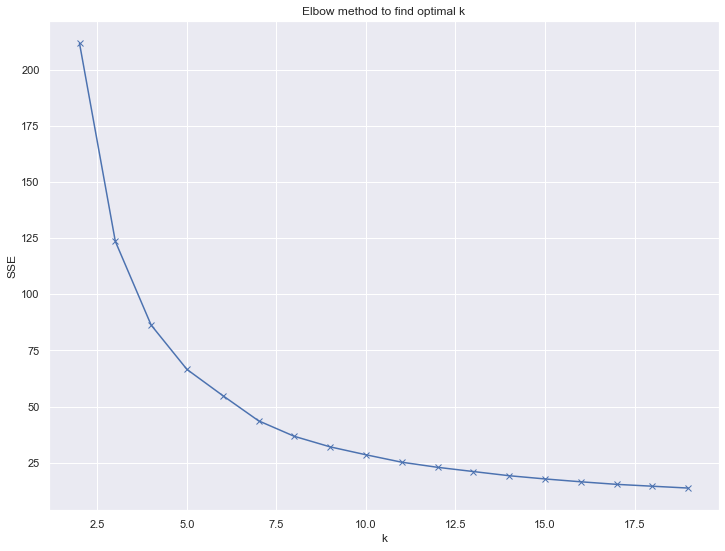

In [58]:
elbow_plot(size_vars, X_train_scaled)


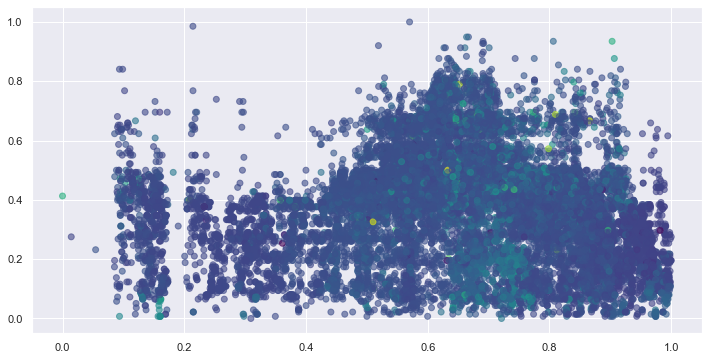

In [88]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X_train_scaled.age_scaled, x=X_train_scaled.longitude_scaled,c=X_train_scaled.taxrate_scaled,cmap='viridis',vmin=0 ,alpha=.6)


In [91]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_train_scaled)

In [93]:
train_clusters.size_cluster.value_counts()

2    10079
1     9270
3     5410
0     2526
4      670
Name: size_cluster, dtype: int64

In [102]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_train, X_train_scaled = X_train_scaled)


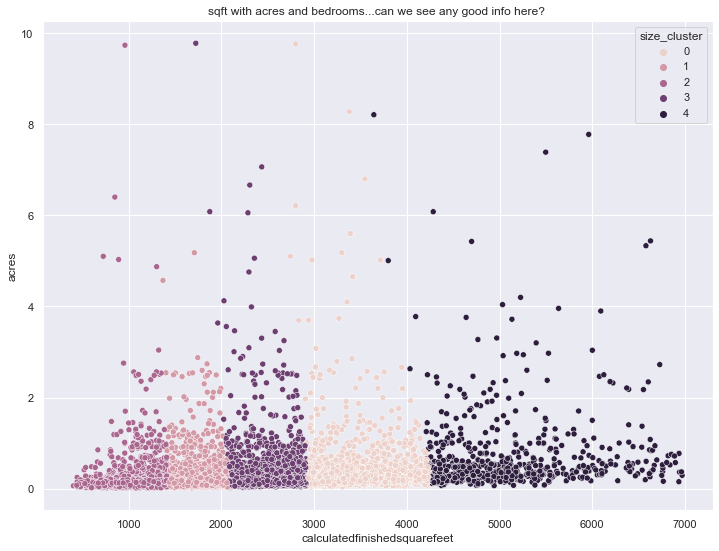

In [103]:
sns.scatterplot(x='calculatedfinishedsquarefeet', y='acres', hue='size_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

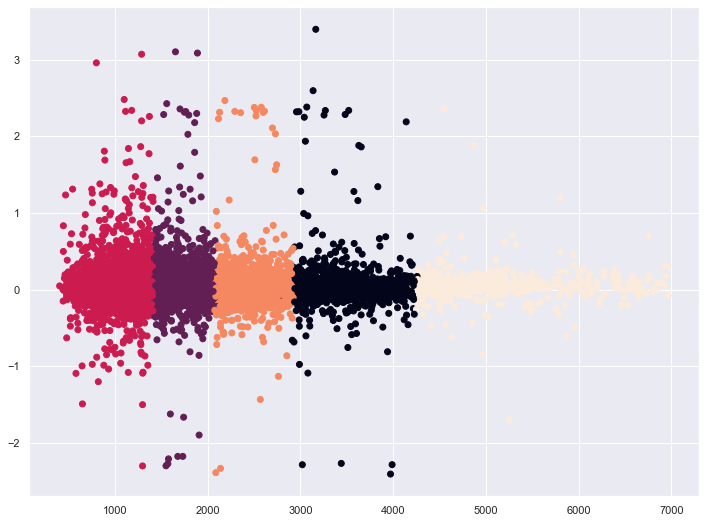

In [104]:
plt.scatter(X_train.calculatedfinishedsquarefeet, y_train.error, c=X_train.size_cluster)
plt.show()

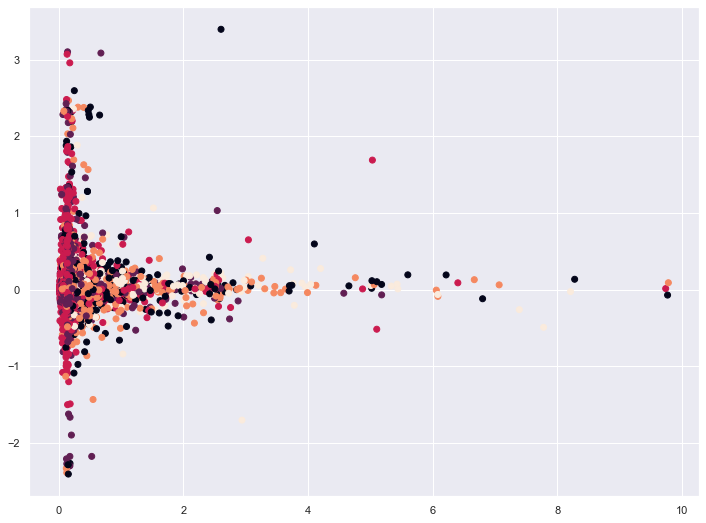

In [105]:
plt.scatter(X_train.acres, y_train.error, c=X_train.size_cluster)
plt.show()


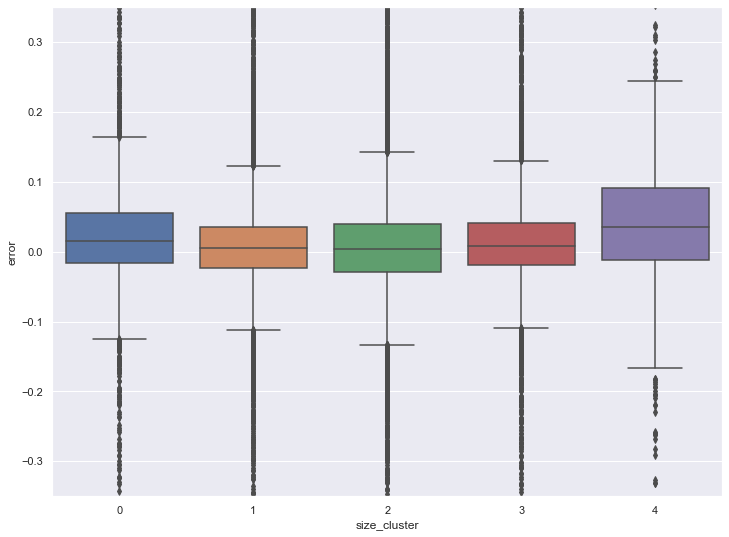

In [119]:
sns.boxplot(X_train.size_cluster, y_train.error)
plt.ylim(-.35,.35)
plt.show()

In [120]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      27955 non-null  int64   
 1   bedroomcnt                    27955 non-null  float64 
 2   calculatedfinishedsquarefeet  27955 non-null  float64 
 3   fireplacecnt                  27955 non-null  float64 
 4   latitude                      27955 non-null  float64 
 5   longitude                     27955 non-null  float64 
 6   poolcnt                       27955 non-null  float64 
 7   regionidcity                  27955 non-null  float64 
 8   regionidzip                   27955 non-null  float64 
 9   roomcnt                       27955 non-null  float64 
 10  transactiondate               27955 non-null  object  
 11  heatingorsystemdesc           27955 non-null  object  
 12  age                           27955 non-nu

In [125]:

f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)
p

3.6987223368517235e-08

In [126]:
alpha = 0.5

In [128]:
p < alpha

True

In [121]:
cluster0 = train[train.size_cluster == 0].error
cluster1 = train[train.size_cluster == 1].error
cluster2 = train[train.size_cluster == 2].error
cluster3 = train[train.size_cluster == 3].error
cluster4 = train[train.size_cluster == 4].error

In [123]:
X_validate_scaled, X_test_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_validate_scaled, X_train_scaled = X_test_scaled)


In [124]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

     k           sse
0    2  3.429006e+02
1    3  1.487554e+02
2    4  5.300229e+01
3    5  3.222906e+01
4    6  8.071085e+00
5    7  3.809558e+00
6    8  6.694602e-01
7    9  1.772727e-01
8   10  9.635247e-25
9   11  9.693862e-25
10  12  9.693969e-25
11  13  9.693777e-25
12  14  9.753401e-25
13  15  9.754044e-25
14  16  9.753088e-25
15  17  9.754044e-25
16  18  9.818070e-25
17  19  9.818790e-25


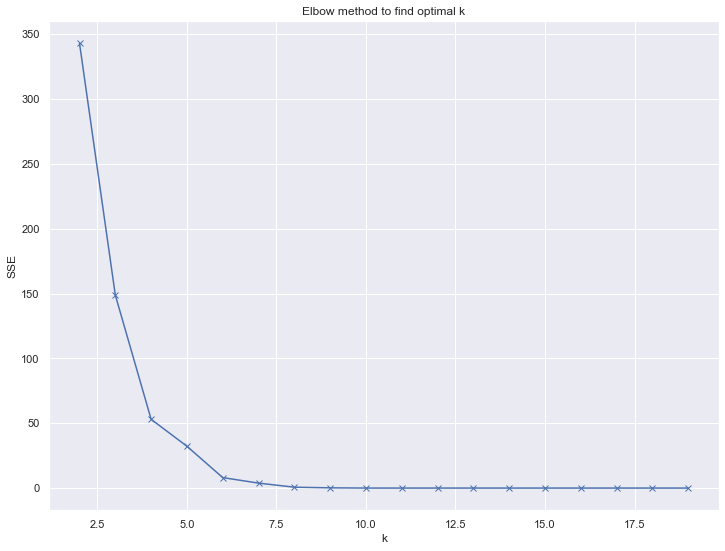

In [129]:
elbow_plot(feature_vars, X_train_scaled)

In [130]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_train_scaled)

In [131]:
train_clusters.feature_cluster.value_counts()


0    19450
1     4765
2     2768
3      972
Name: feature_cluster, dtype: int64

In [132]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'feature_cluster', X_train = X_train, X_train_scaled = X_train_scaled)


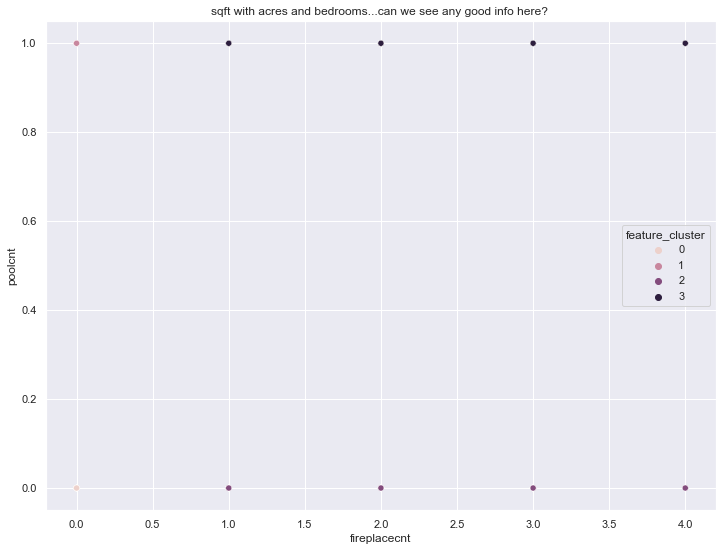

In [133]:
sns.scatterplot(x='fireplacecnt', y='poolcnt', hue='feature_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()